# Introducción

El objetivo de este proyecto es generar imágenes realistas de rostros de gatos utilizando una red neuronal autoencoder variacional (VAE). Este tipo de red es capaz de crear nuevas representaciones visuales que imitan la apariencia de los rostros de gatos, basándose en la estructura y los patrones presentes en los datos de entrenamiento.

## Configuración del repositorio

### Para ejecutar en Colab

Si se ejecuta este notebook en Google Colab, se debe subir el repositorio a Google Drive y ejecutar las siguientes celdas:

In [ ]:
import os
try:
    from google.colab import drive
    using_colab = True
except ModuleNotFoundError:
    using_colab = False

Además, se debe dar permisos para acceder a la cuenta de Google Drive y configurar la constante `DATASET_PATH` con la dirección al dataset:

In [ ]:
if using_colab:
    drive.mount('/content/drive')
    REPO_PATH = "/content/drive/MyDrive/Repositories/Generación de rostros de gatos/" # Configurar según path en Google Drive
else:
    REPO_PATH = ".."

DATASET_PATH = os.path.join(REPO_PATH , "data", "cats")

### Descarga del Dataset

El dataset se encuentra en el archivo comprimido `data/cats.zip`. Para ejecutar el notebook, es necesario descomprimir este archivo. Si estamos en Colab, se puede ejecutar la siguiente celda: 

In [ ]:
!unzip "/content/drive/MyDrive/Repositories/Generación de rostros de gatos/data/cats.zip"  -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/cats/5499.jpg  
  inflating: /content/cats/55.jpg    
  inflating: /content/cats/550.jpg   
  inflating: /content/cats/5500.jpg  
  inflating: /content/cats/5501.jpg  
  inflating: /content/cats/5502.jpg  
  inflating: /content/cats/5503.jpg  
  inflating: /content/cats/5504.jpg  
  inflating: /content/cats/5505.jpg  
  inflating: /content/cats/5506.jpg  
  inflating: /content/cats/5507.jpg  
  inflating: /content/cats/5508.jpg  
  inflating: /content/cats/5509.jpg  
  inflating: /content/cats/551.jpg   
  inflating: /content/cats/5510.jpg  
  inflating: /content/cats/5511.jpg  
  inflating: /content/cats/5512.jpg  
  inflating: /content/cats/5513.jpg  
  inflating: /content/cats/5514.jpg  
  inflating: /content/cats/5515.jpg  
  inflating: /content/cats/5516.jpg  
  inflating: /content/cats/5517.jpg  
  inflating: /content/cats/5518.jpg  
  inflating: /content/cats/5519.jpg  
  inflating: /content/cats/552.jpg   

## Librerías a utilizar

In [3]:
import os
from typing import Optional, Callable

import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Dataset de Gatos

Para abordar este proyecto, utilizamos el dataset [Cats Faces 64x64 (for generative models)](https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models/data). Este conjunto de datos contiene imágenes de rostros de gatos en resolución $64 \times 64$ y formato RGB, lo que lo hace ideal para tareas de generación y síntesis de imágenes al reducir la complejidad computacional sin sacrificar detalles relevantes. 

El dataset incluye un total de 15,747 imágenes, todas etiquetadas bajo una única clase, gatos. Aunque no cuenta con una documentación detallada, la calidad y uniformidad de las imágenes permiten centrarse exclusivamente en la generación de rostros de gatos, eliminando la variabilidad de múltiples dominios presente en otros datasets más complejos.

## Configuración del Dataset

A continuación se crea la clase `CatsDataset` que recibe como parámetro la dirección del dataset y una transformación a aplicar al dataset:

In [ ]:
class CatsDataset(Dataset):
    def __init__(
            self,
            dataset_path: str,
            transform: Optional[Callable] = None,
        ):
        images_names = os.listdir(dataset_path)

        self.X = []
        print(f"[-] Cargando imágenes de {dataset_path}:")
        for image_name in tqdm(images_names):
            img_path = os.path.join(dataset_path, image_name)

            image = Image.open(img_path)
            if transform:
                image = transform(image)
            self.X.append(image)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], 0

Se crea una transformación que convierte los arreglos a tensores, y además se aplica un resize para asegurarnos de que todas las imágenes tengan las dimensiones $64 \times 64$:

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

Por último, se instancia el dataset:

In [ ]:
cat_dataset = CatsDataset(DATASET_PATH, transform=transform)


[-] Cargando imágenes de cats:
100%|██████████| 15747/15747 [00:16<00:00, 946.44it/s] 



## Exploración de Datos

Antes de entrenar nuestro modelo, es crucial inspeccionar visualmente algunas muestras del dataset para verificar la calidad de las imágenes. Para esto, se crea una función que muestra un conjunto de imágenes seleccionadas del dataset:

In [ ]:
def plot_images(dataset: CatsDataset, indexes: list[int]):
    fig, axs = plt.subplots(1, len(indexes), figsize=(len(indexes), len(indexes)))
    for i, idx in enumerate(indexes):
        img, _ = dataset[idx]
        img = img.permute(1, 2, 0)
        axs[i].imshow(img)
        axs[i].set_title(f"Cat n°{idx}")
        axs[i].axis("off")
    
    plt.show()

Ejecutamos esta función para visualizar ejemplos de las imágenes en nuestro conjunto de entrenamiento:

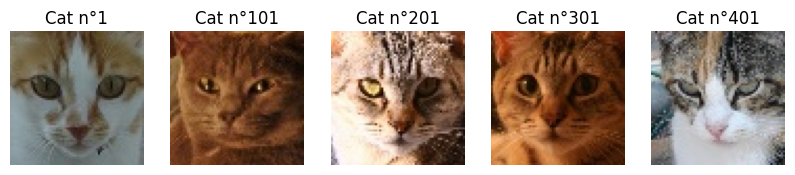

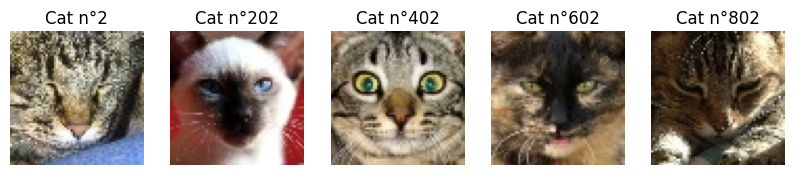

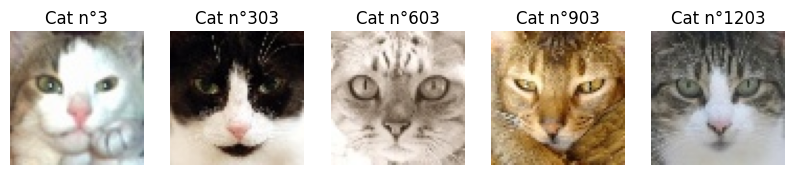

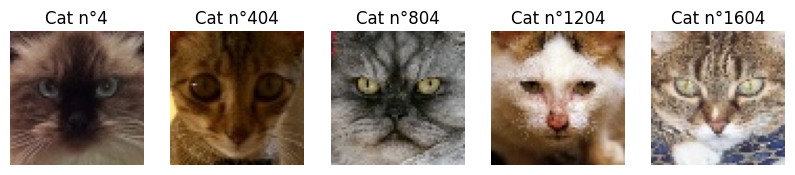

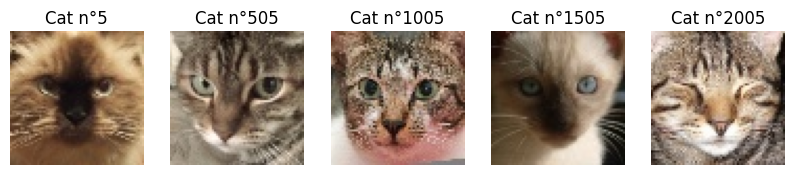

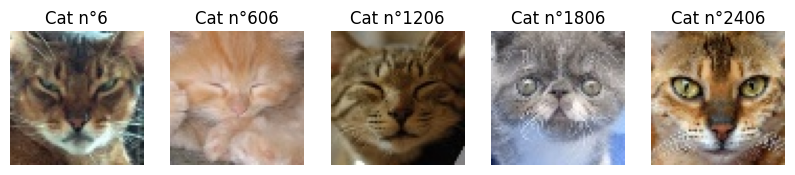

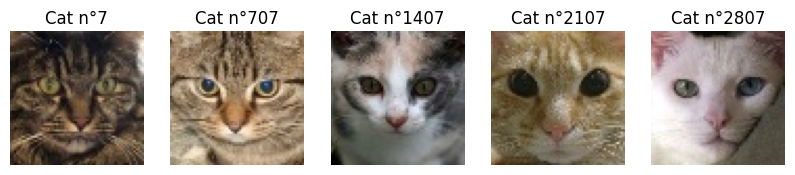

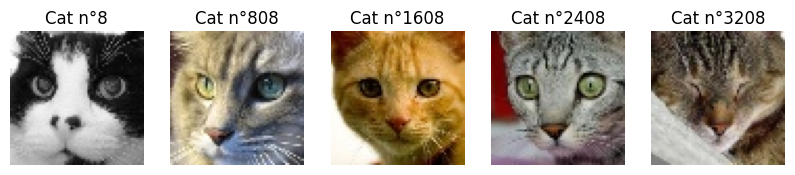

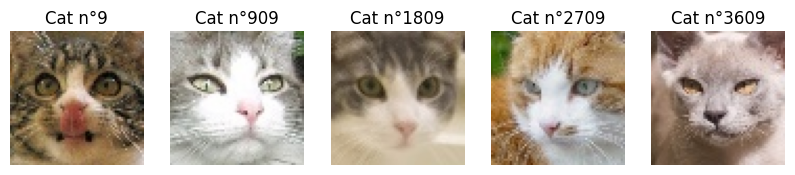

In [30]:
for i in range(1, 10):
    plot_images(cat_dataset, indexes=[1*i, 101*i, 201*i, 301*i, 401*i])


# Conclusión

Se puede concluir que el dataset es altamente adecuado para tareas de generación de imágenes, ya que presenta características consistentes y de calidad. Las imágenes están correctamente recortadas, con un mínimo de fondo, lo que asegura que el rostro del gato ocupa la mayor parte de cada fotografía. Esto reduce la complejidad asociada con variaciones en el entorno o en los elementos de fondo.

Además, se observa una homogeneidad en las poses, ya que la mayoría de los rostros están orientados de frente y mantienen una posición similar en todas las muestras. Esta uniformidad facilita que el modelo generativo enfoque su aprendizaje en las características específicas de los rostros de gatos, incrementando así la probabilidad de obtener resultados coherentes y detallados durante la síntesis de nuevas imágenes.